In [2]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

# Semantic Segmentation

Semantic Image Segmentation is the process of partitioning the image into multiple segments (sets of individual pixels). The goal is pixel level classification of the various classes that we define, usually as part of a process to make the image easier to analyze.

The result of image segmentation is a set of segments that collectively cover the entire image. Each of the pixels in a region are similar with respect to some characteristic or computed property, such as color, intensity, texture or class label. Adjacent regions are significantly different with respect to the same characteristic(s). When applied to a stack of images, typical in medical imaging, the resulting contours after image segmentation can be used to create 3D reconstructions with the help of interpolation algorithms like marching cubes.

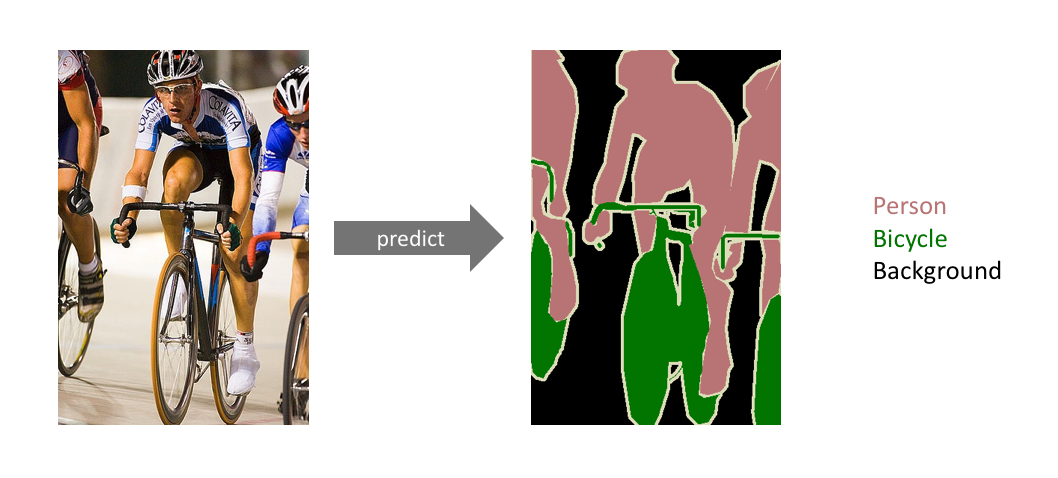
[[1](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit)]

There are [many](https://www.wikiwand.com/en/Image_segmentation) existing simple non neural-networks methods to segment images that often are ony based on the color information of the pixels in the image. However us as humans use much more knowledge when performing image segmentation, thus we can use neural networks to learn to encode the best features for this.


## Image Segmentation in Keras

Lets use the the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) for our image segmentation problem. The dataset consists of images, their corresponding labels, and pixel-wise masks [[2](https://www.tensorflow.org/tutorials/images/segmentation)]. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   **Class 1** : Pixel belonging to the pet
*   **Class 2** : Pixel bordering the pet
*   **Class 3** : None of the above or Surrounding pixel


In [3]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

We can pre-process the data to by augmenting it, to randomly flip an image along the horizontal, and scale the image to be between 0 and 1. The pixels in the segmentation mask come as one of $\{1,2,3\}$, here we subtract one from the segmentation mask, thus we get labels of the set $\{0,1,2\}$.

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

The dataset already has already split the test and training data up for us, so we can reuse this

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

We can visulize an image example and it's corresponding mask from the dataset

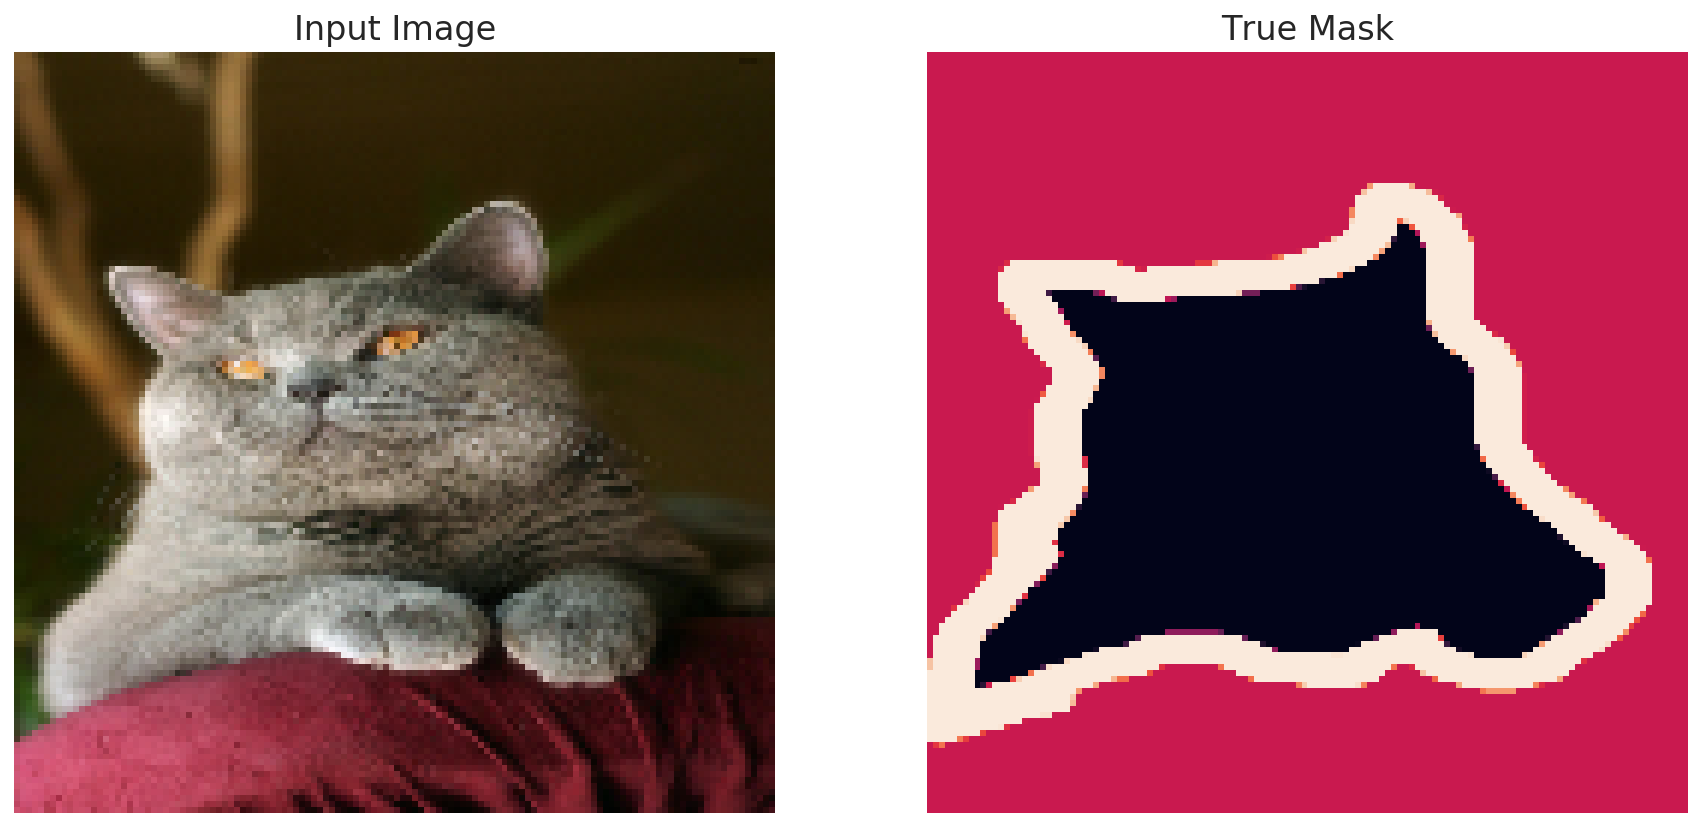

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in train.take(3):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Semantic Image Segmentation Model

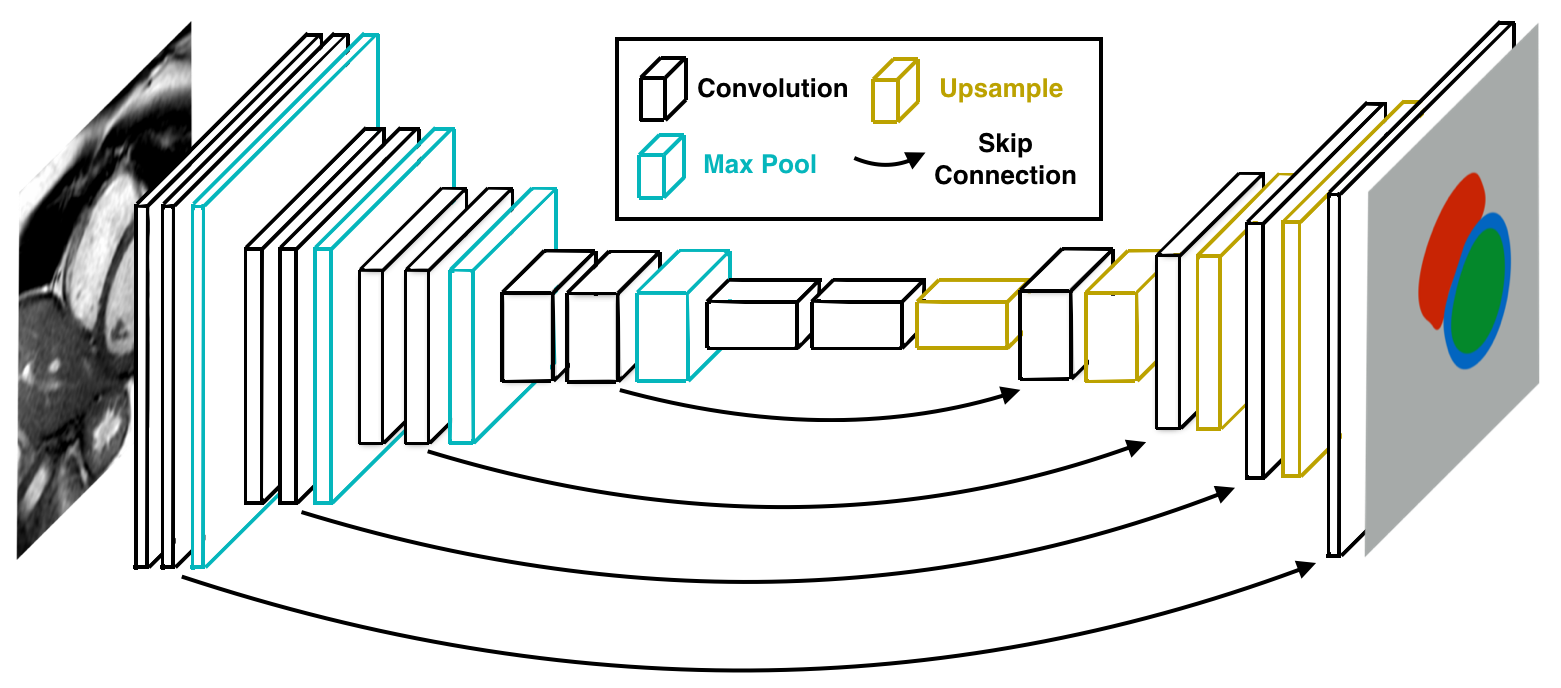
[[3](https://www.groundai.com/project/fastventricle-cardiac-segmentation-with-enet/)]

Let's use an empirically well performing architecture pattern, that of a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). We can see a representation of the network above, it is similar to a convolutional autoencoder with skip connections. That it is has a convolutional encoder and decoder, along with skip connections (shortcuts over the layers). The skip connections allow us to pass on low level information, such as the boundaries of the segmentation, allowing us to create accurate boundaries in the output.

## Transfer learning in practice

In practice, due to our limits of computational power and most likely a small dataset (compared to ImageNet approx. 14 million images), we can use pre-trained ConvNets for the encoder layers of the segmentation model. We can re-use the convolution layers of Resnet, VGG or MobileNetV2 pre-trained on the ImageNet dataset.

Here we will use [MobileNetV2](https://arxiv.org/abs/1801.04381), whose intermediate outputs will be used, and the decoder will be upsample blocks.

The output channels, or depth of the $3D$ volume output is the number of classes we are trying to predict. Each layer learns a one versus rest multi-classification pixel mask. We have $3$ classes here so the output volume is of depth $3$, i.e. three channels.

The encoder consists of specific outputs from intermediate layers in the model. Here we will not train the encoder during the training, for this application of transfer learning.

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

The decoder is a series of upsample blocks

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [9]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Training our model

We can compile and train our model now. As we are trying to assign each pixel a label, just like multi-class prediction, we will use the `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` function. In the true segmentation mask, each pixel has is one of three classes ($\{0,1,2\}$). From the output of the network the label that is assigned to the pixel is the channel with the highest value (this is what the function `create_mask` does).

In [10]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

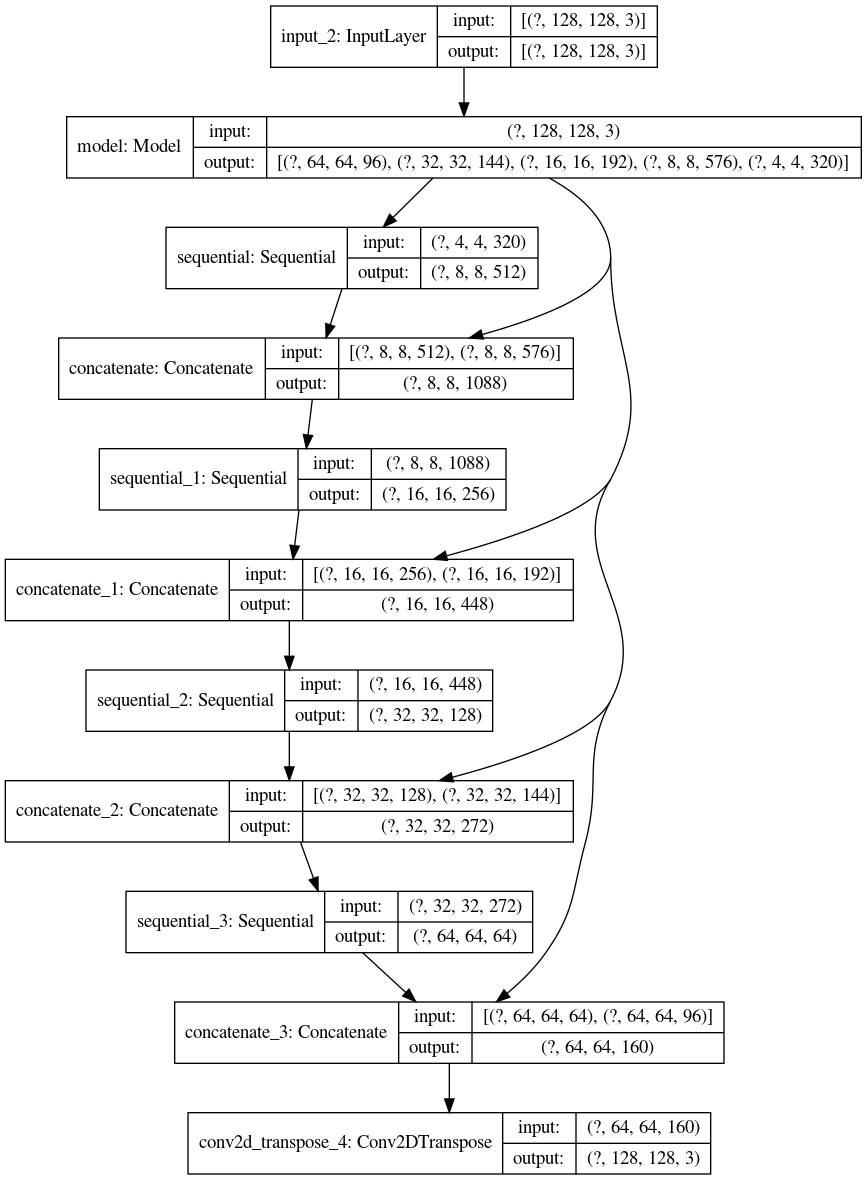

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

We can test our untrained model to see what it predicts before training

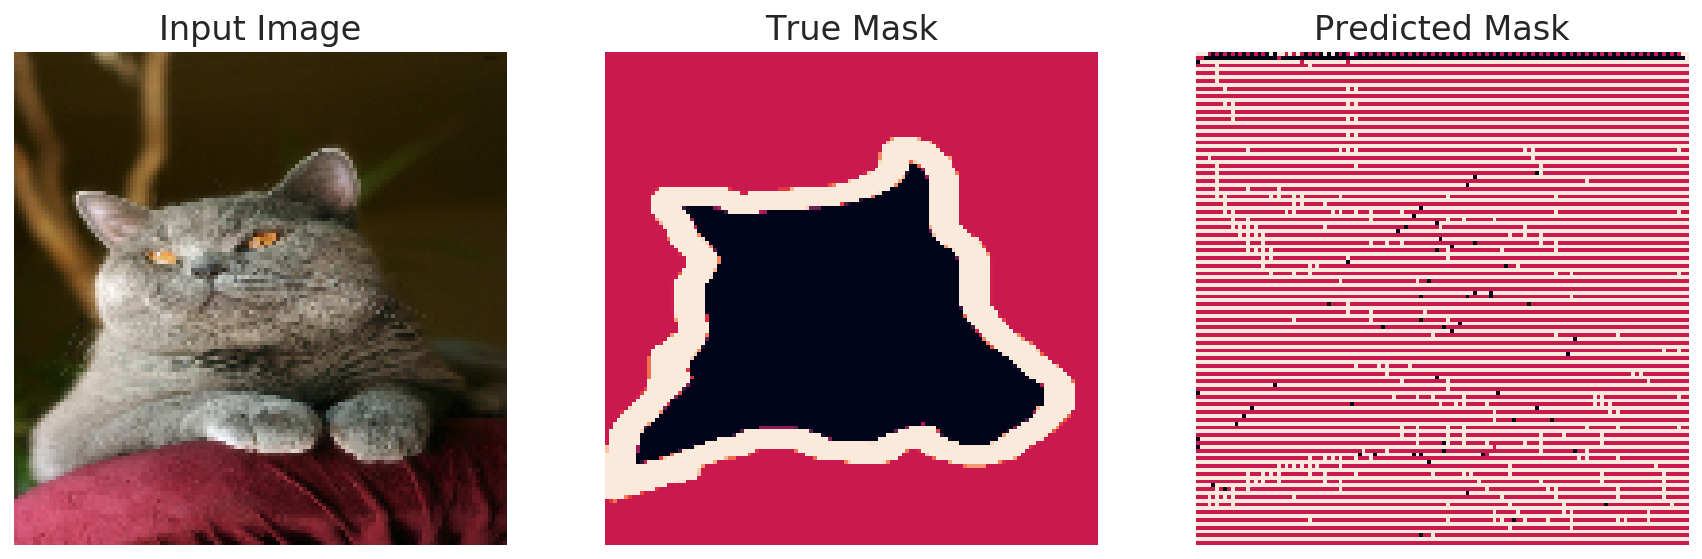

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
show_predictions()

We can use a custom callback to visualize how the model improves whilst training. 

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

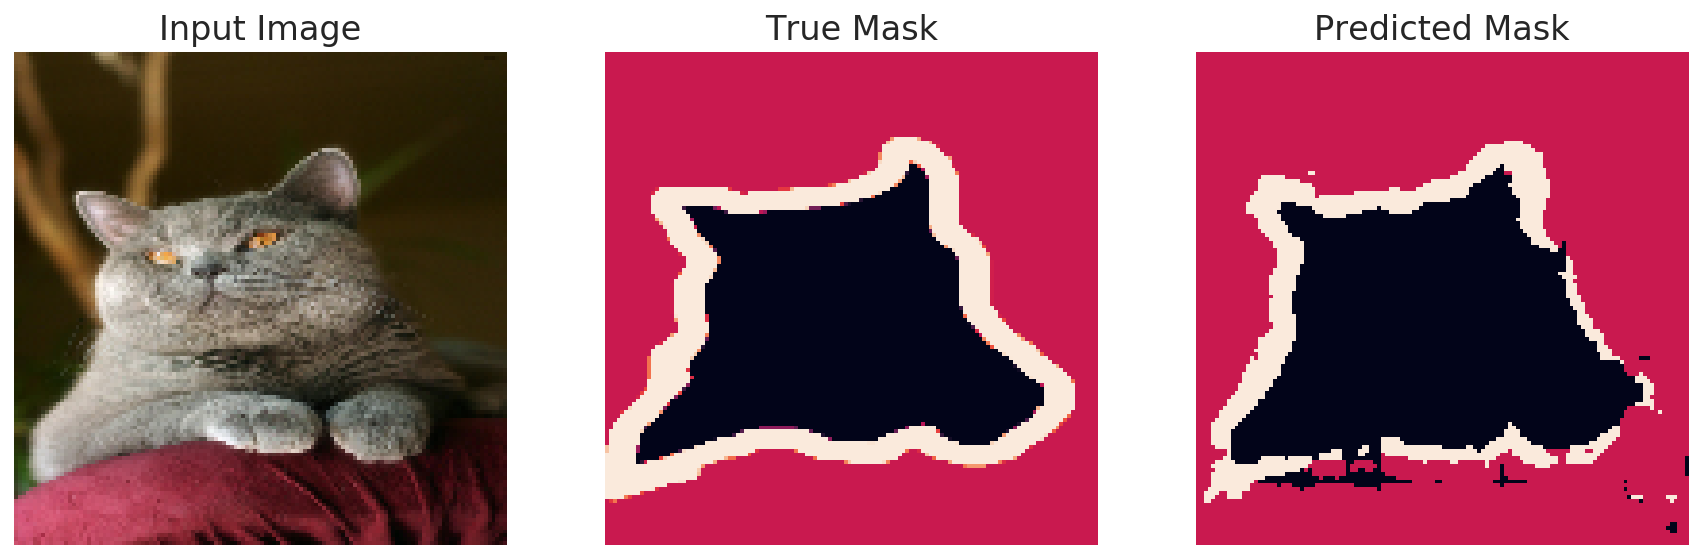


Sample Prediction after epoch 20

57/57 [==============================] - 4s 68ms/step - loss: 0.1450 - accuracy: 0.9344 - val_loss: 0.3640 - val_accuracy: 0.8782


In [20]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

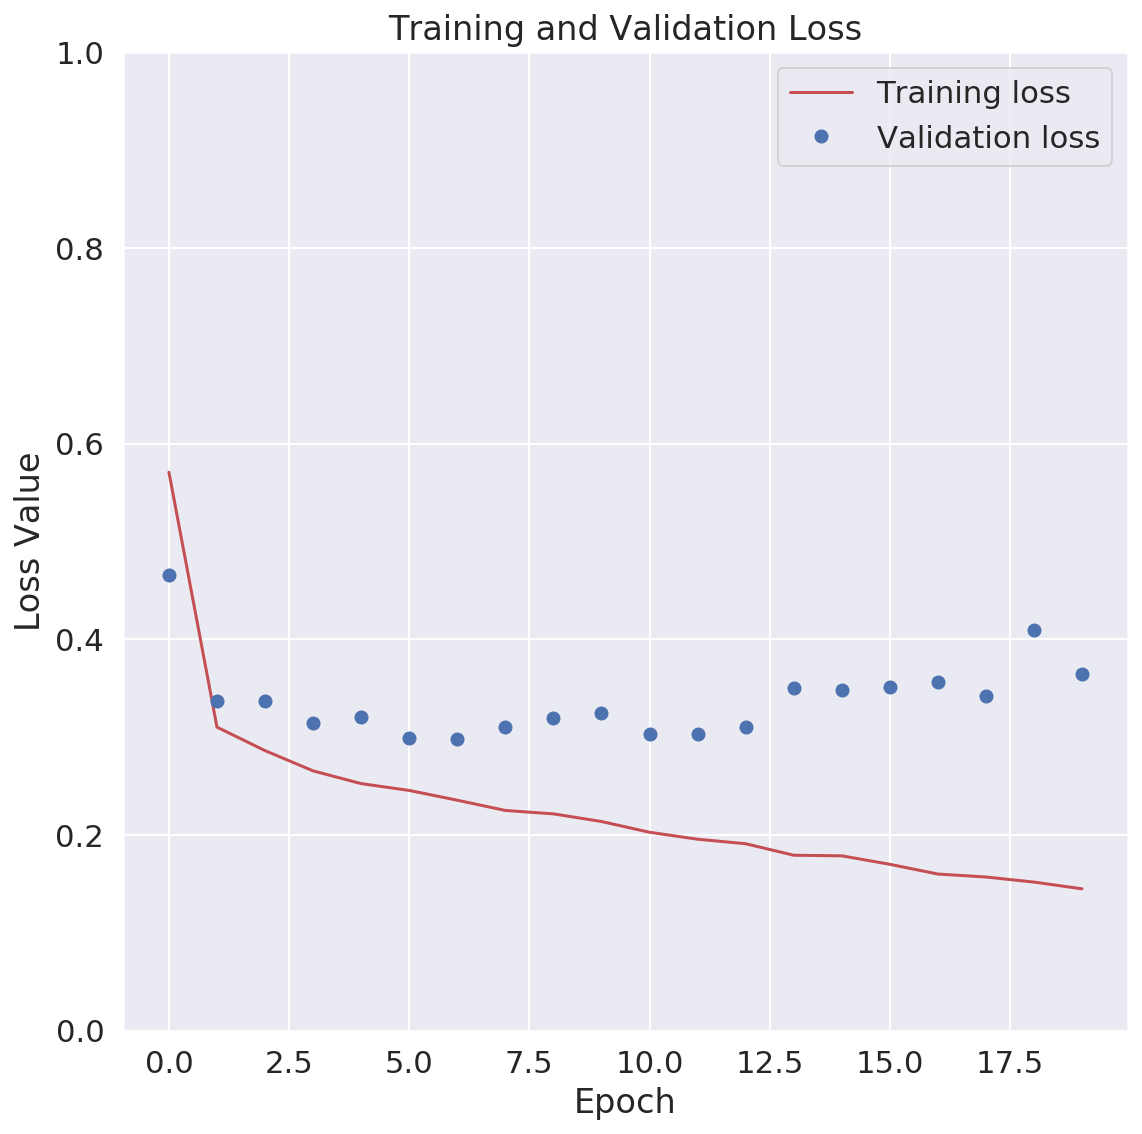

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Making predictions

We can use the model to make some predictions. In practice we may use a larger number of epochs to achieve more accurate results.

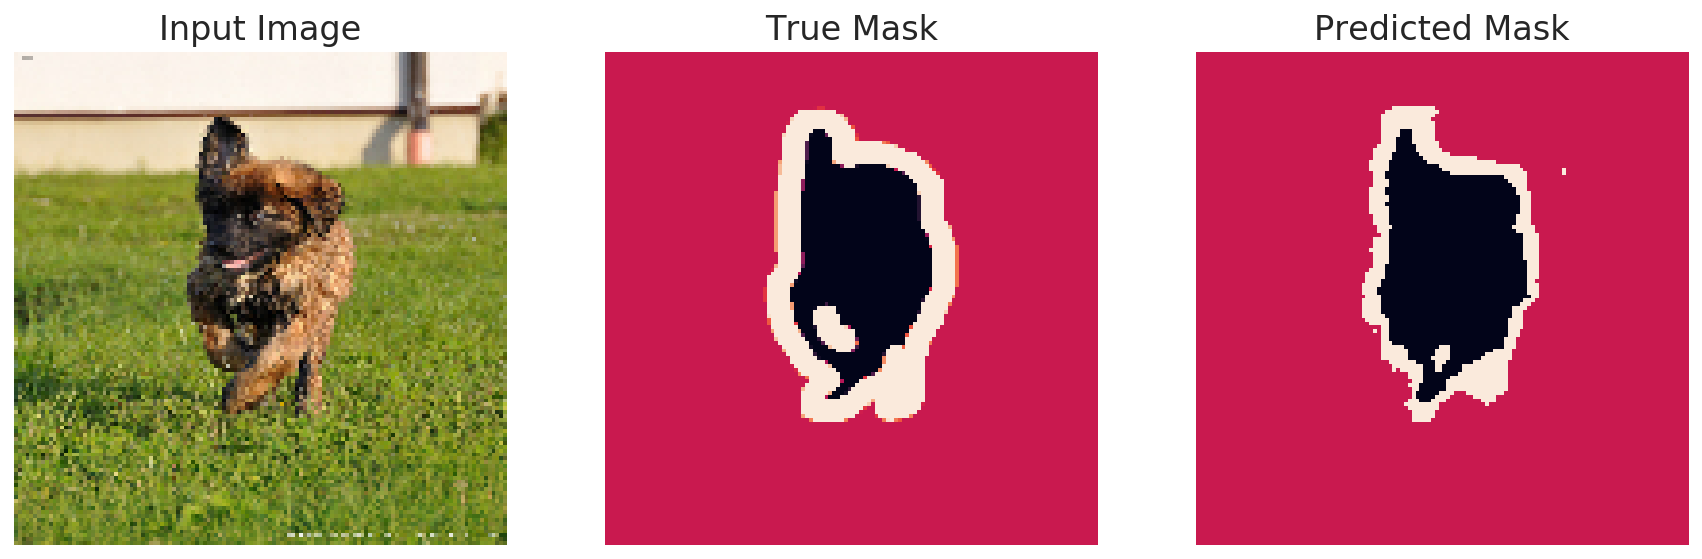

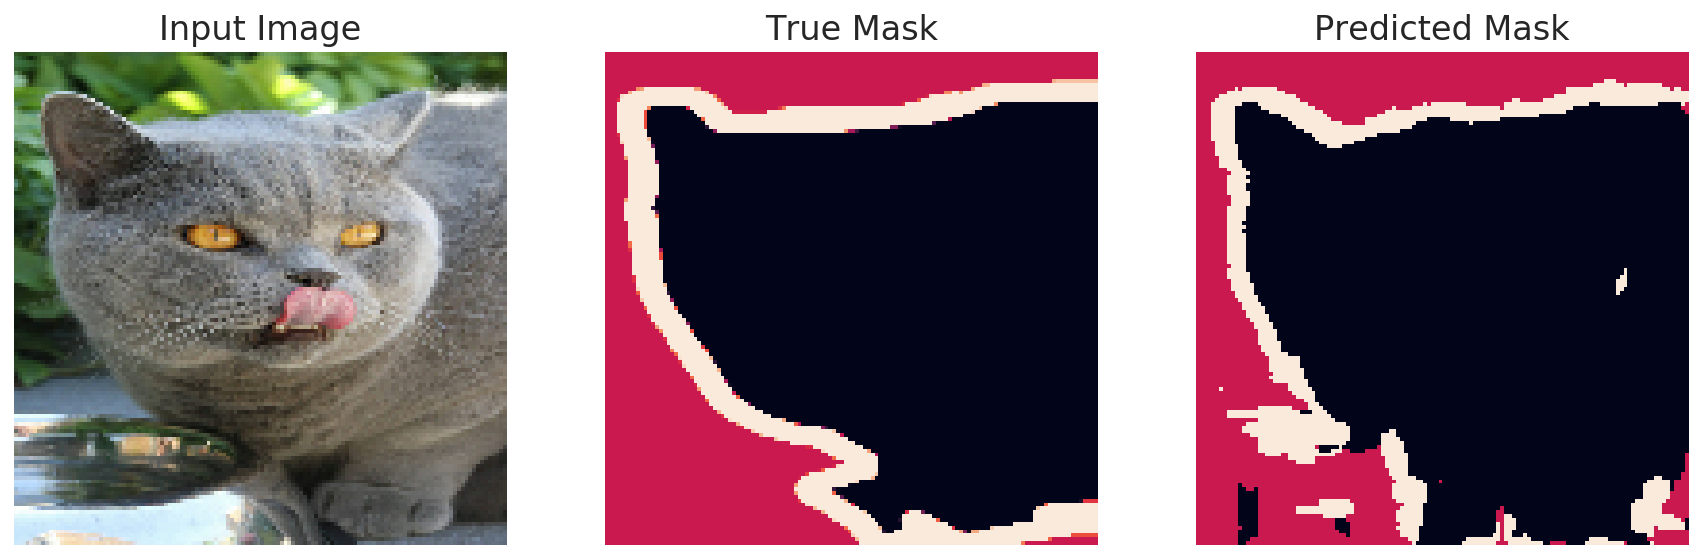

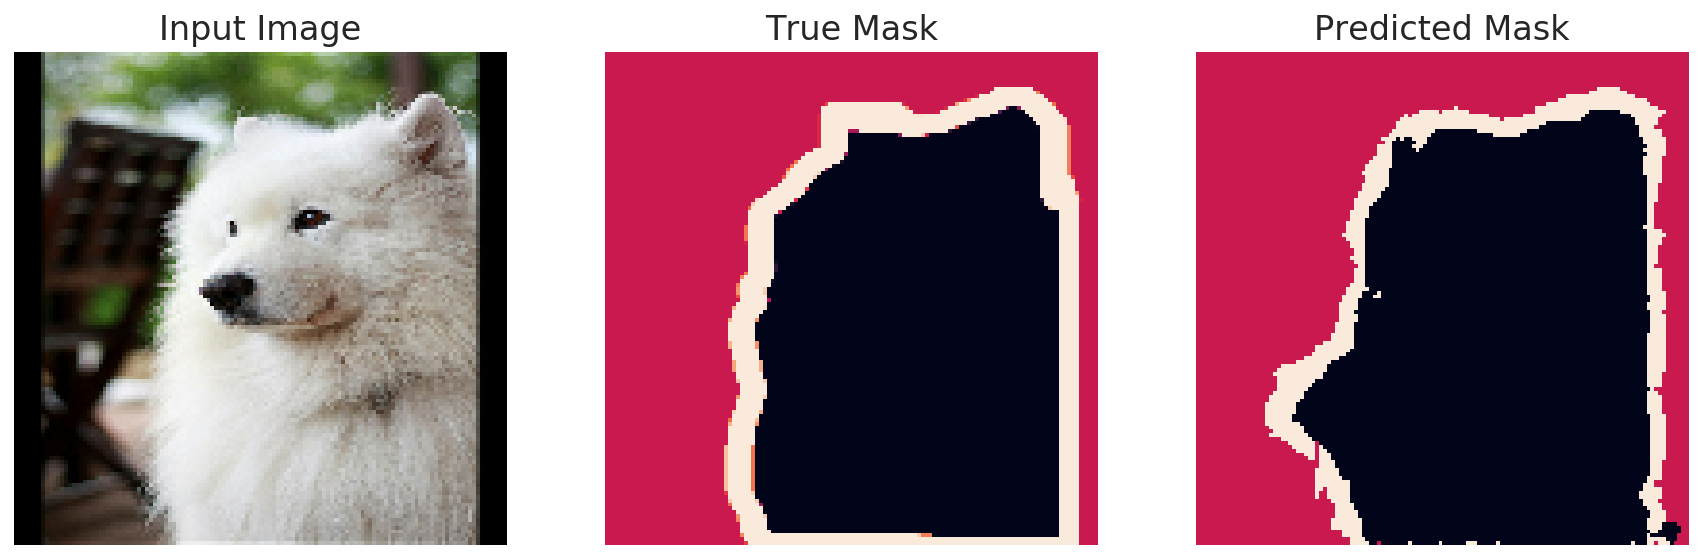

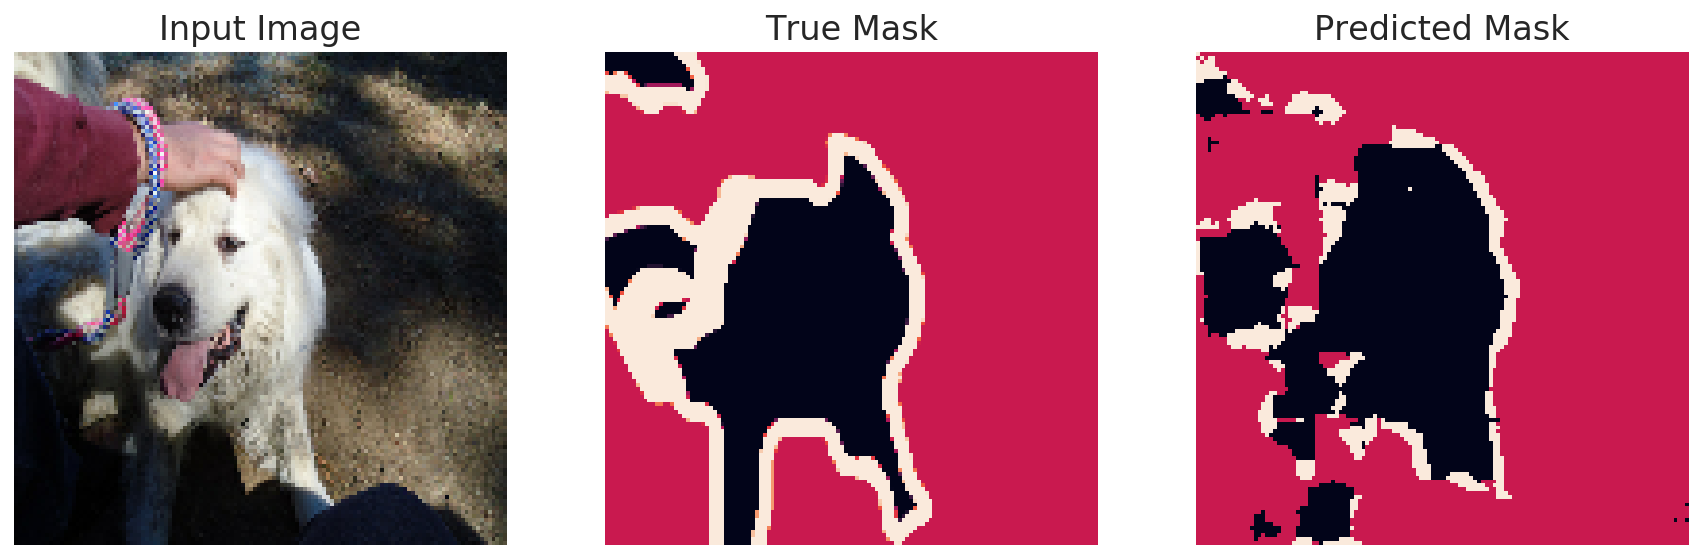

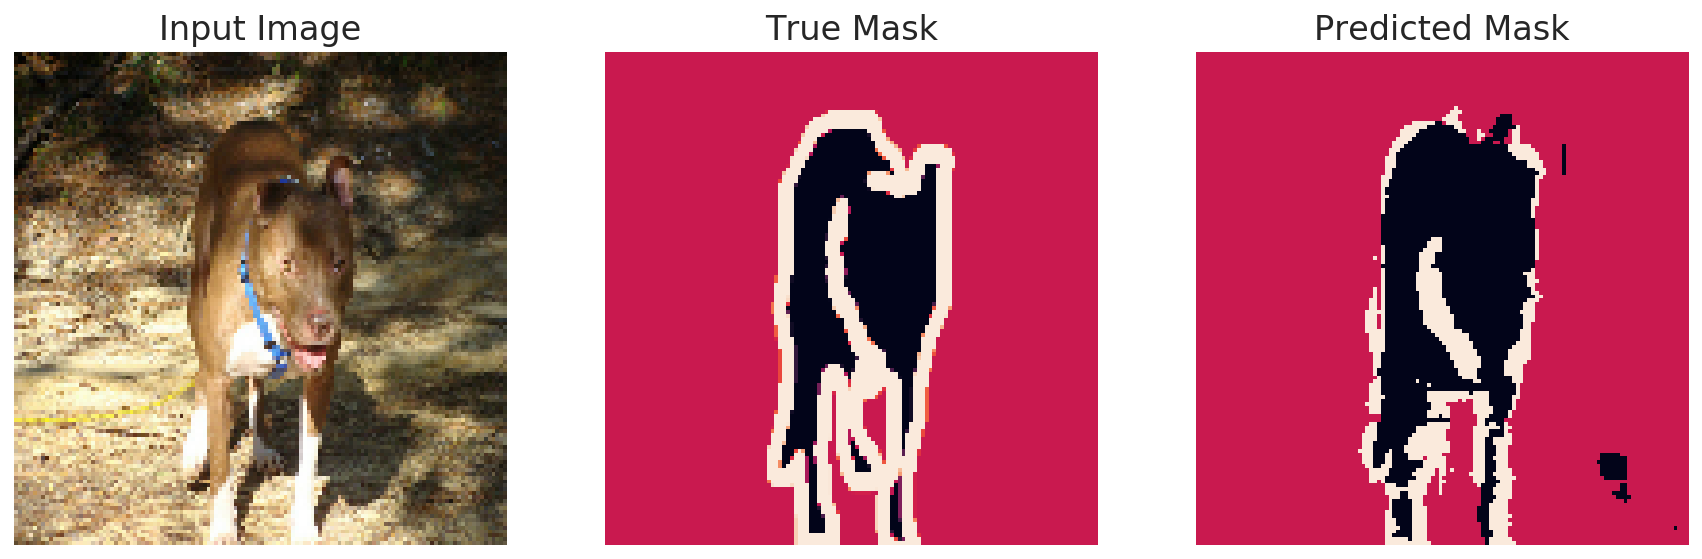

In [23]:
show_predictions(test_dataset, 5)